# Development Consistency of Popular Repos

Notes
- Main Dataset https://www.kaggle.com/datasets/johntukey/github-dataset
- Related Paper https://www.diva-portal.org/smash/get/diva2:1114676/FULLTEXT01.pdf

1. Import modules

In [11]:
from datetime import datetime, timedelta, timezone
import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics

2. Load JSON dataset

In [12]:
# paste file directory below
path = "dataset.json"

df = pd.read_json( path, lines = True )

3. Add commit list to repos

In [13]:
# function to create a list of repos with their commits
def addCommitListToRepos(df):

    # main dataset only keeps username, user id, number of commits, and commit list
    df = df[ [ "login", "id", "commits", "commit_list" ] ]

    # copy of the dataset used only for iterating through each user's commit lists
    commitLists = df.copy()

    # only keep commit list
    commitLists = commitLists[ "commit_list" ]

    # add commits to repos
    reposWithCommits = {}
    for currList in commitLists:
        for commit in currList:
            if commit[ "repo_id" ] not in reposWithCommits:
                reposWithCommits[ commit[ "repo_id" ] ] = []
            reposWithCommits[ commit[ "repo_id" ] ].append( commit )

    # return repos with commits for further use in this notebook
    return reposWithCommits

In [14]:
def printReposWithCommits(reposWithCommits, max_repos=5, max_commits_per_repo=10):
    # Create a shallow copy of the dictionary to avoid mutating the original data
    limitedReposWithCommits = dict(list(reposWithCommits.items())[:max_repos])
    
    # Limit the number of commits per repository
    for repo_id, commits in limitedReposWithCommits.items():
        limitedReposWithCommits[repo_id] = commits[:max_commits_per_repo]

    # Convert the limited dictionary to a JSON string with indentation for readability
    reposWithCommitsJson = json.dumps(limitedReposWithCommits, indent=4)
    print(reposWithCommitsJson)

4. Initialize a dictionary with keys of repo IDs and values of a list of commits to that repo

In [15]:
reposWithCommits = addCommitListToRepos(df)

# Call the function with your data, specifying how many repos and commits per repo to print
printReposWithCommits(reposWithCommits, max_repos=5, max_commits_per_repo=10)

{
    "98311519": [
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:56:08.000-03:00",
            "committer_id": 30438508,
            "message": "Set theme jekyll-theme-merlot",
            "repo_description": null,
            "generate_at": "2017-07-25 10:56:08.000-03:00",
            "author_id": 30438508,
            "repo_name": "MelLobo/Fonte"
        },
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:52:25.000-03:00",
            "committer_id": 19864447,
            "message": "Create README.md",
            "repo_description": null,
            "generate_at": "2017-07-25 10:52:25.000-03:00",
            "author_id": 30438508,
            "repo_name": "MelLobo/Fonte"
        },
        {
            "repo_id": 98311519,
            "repo_owner_id": 30438508,
            "commit_at": "2017-07-25 10:54:36.000-03:00",
            "co

5. Test for proper intialization of reposWithCommits

In [16]:
# Assuming reposWithCommits is a dictionary where keys are repo IDs and values are lists of commits

# Calculate the total number of repos
total_repos = len(reposWithCommits.keys())

# Calculate the total number of commits
numCommits = sum(len(commitList) for commitList in reposWithCommits.values())

# Data for specific repo IDs
repo_ids = [121300003, 88377551, 131508193, 132465788, 132464776]
repos_data = {repo_id: reposWithCommits[repo_id] for repo_id in repo_ids if repo_id in reposWithCommits}

# Structuring the data
data_to_print = {
    "Total number of repos": total_repos,
    "Total number of commits": numCommits,
    "repos": repos_data
}

# Pretty printing the data as JSON
print(json.dumps(data_to_print, indent=4))

{
    "Total number of repos": 447111,
    "Total number of commits": 4544737,
    "repos": {
        "121300003": [
            {
                "repo_id": 121300003,
                "repo_owner_id": 27222462,
                "commit_at": "2018-02-12 21:48:21.000+01:00",
                "committer_id": 19864447,
                "message": "Initial commit",
                "repo_description": "Web parsing using Beautiful soup lib in Python",
                "generate_at": "2018-02-12 21:48:21.000+01:00",
                "author_id": 27222462,
                "repo_name": "Nandrajog93/Beautiful-Soup-"
            },
            {
                "repo_id": 121300003,
                "repo_owner_id": 27222462,
                "commit_at": "2018-02-12 21:48:52.000+01:00",
                "committer_id": 19864447,
                "message": "Create README.md",
                "repo_description": "Web parsing using Beautiful soup lib in Python",
                "generate_at": "2018-02-12 2

6. Calculate time between each commit for every repo

In [17]:
def timeBetweenCommits( reposWithCommits ):

    timeBetweenList =[]
    currTimeBetweenList = []
    currTimeList = []
    avgTimeList = []
    medianTimeList = []

    # iterate through all commits lists in reposWithCommits
    for currCommitList in reposWithCommits.values():
        # ignore repos with only 1 or 0 commits
        if len( currCommitList ) <= 1:
            avgTimeList.append( timedelta() )
            medianTimeList.append( timedelta() )
            timeBetweenList.append( [] )
            continue

        # build list of commit timestamps for every repo
        for commit in currCommitList:
            currTimeList.append( commit[ "commit_at" ] )

        # iterate through all commit timestamps for a repo
        for i in range( len(currTimeList) ):
            currTimeZone = currTimeList[i][-1]
            currTimestamp = datetime.fromisoformat( currTimeList[i][:19] )

            # convert all timestamps to UTC based on their time zone
            if currTimeZone == 'Z':
                 # Z represents no offset meaning commited in UTC time zone
                 currTimestamp = currTimestamp.replace( tzinfo = timezone.utc )
            else:
                # get offset from the last 6 characters in the timestamp
                currTimeZone = currTimeList[i][-6:]

                # parse the offset
                h, m = map( int, currTimeZone.split(":") )
                if h < 0:
                    m *= -1
                currTimeZone = timedelta( hours = h, minutes = m )
                currTimeZone = timezone( currTimeZone )
                currTimestamp = currTimestamp.replace( tzinfo = currTimeZone ).astimezone( timezone.utc )

            currTimeList[i] = currTimestamp

        # sort commit timestamps in ascending order
        currTimeList = sorted( currTimeList )

        # calculate time between each commit
        currAvgTime = timedelta()
        for i in range( len(currTimeList) - 1 ):
            currTimeBetweenList.append( currTimeList[i + 1] - currTimeList[i] )
            currAvgTime = currAvgTime + ( currTimeList[i + 1] - currTimeList[i] )

        # calculate average time and append to average time list
        currAvgTime = currAvgTime / ( len( currCommitList ) - 1 )
        medianTimeList.append( statistics.median(currTimeBetweenList) )
        avgTimeList.append( currAvgTime )
        timeBetweenList.append( currTimeBetweenList )
        currTimeList = []
        currTimeBetweenList = []

    # represent reposWithCommits as Pandas DataFrame
    data = { "repo_id": reposWithCommits.keys(),
             "avg_time_between_commits": avgTimeList,
             "median_time_between_commits": medianTimeList }
    data = pd.DataFrame.from_dict( data )

    return data

7. Initialize Pandas DataFrame of time between commits for every repo

In [18]:
repoTimeBetweenCommits = timeBetweenCommits( reposWithCommits )

8. Test for proper initialization of avgTimeBetweenCommits

In [19]:
# Output format of locally stored dataset
#           repo_id avg_time_between_commits median_time_between_commits
# 0        98311519   0 days 00:01:51.500000      0 days 00:01:51.500000
# 1       134804722          0 days 00:00:00             0 days 00:00:00
# 2       134804877          0 days 00:00:00             0 days 00:00:00
# 3       134804933          0 days 00:00:00             0 days 00:00:00
# 4        62891737          0 days 00:00:00             0 days 00:00:00
# ...           ...                      ...                         ...
# 447106   29204775   3 days 07:44:25.241379             0 days 00:25:41
# 447107   60782700   0 days 00:23:15.555556             0 days 00:08:38
# 447108   55134604   1 days 13:25:59.135135             0 days 00:16:37
# 447109   96882560   9 days 07:47:14.730769             0 days 00:48:55
# 447110   74912660   1 days 11:31:33.979592             0 days 00:35:57

# [447111 rows x 2 columns]

avgTime = repoTimeBetweenCommits["avg_time_between_commits"]
midTime = repoTimeBetweenCommits["median_time_between_commits"]

print( "Repos where the difference between avg and median is perfectly 0:", sum( i == timedelta(0) for i in avgTime - midTime ) )

Repos where the difference between avg and median is perfectly 0: 246859


9. Plot difference between average and median of time between commits for every repo

Total number of repos: 447111
Repos with greater than a 1 day difference between mean and median time between commits: 107401
Repos negative difference suggesting a development hiatus 9203


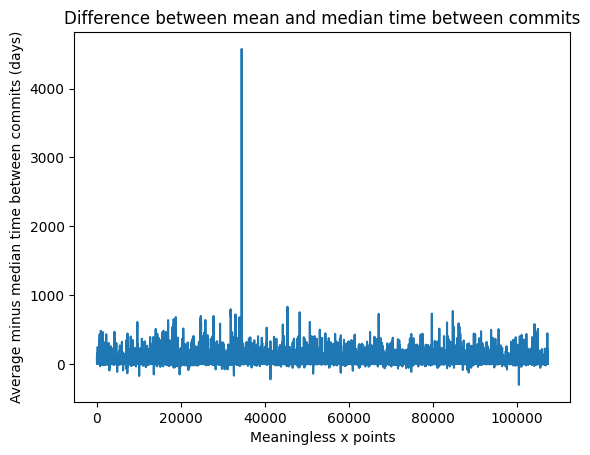

In [20]:
def plotTimeBetweenCommits( avgTime, midTime ):

    ypoints = [ td.days for td in ( avgTime - midTime ) if td.days != 0 ]
    xpoints = [ i for i in range( len(ypoints) ) ]

    print( "Total number of repos:", len(repoTimeBetweenCommits["repo_id"]) )
    print( "Repos with greater than a 1 day difference between mean and median time between commits:", len(ypoints) )
    print( "Repos negative difference suggesting a development hiatus", len( [ td.days for td in ( avgTime - midTime ) if td.days < 0 ] ) )

    plt.title( "Difference between mean and median time between commits" )
    plt.xlabel( "Meaningless x points" )
    plt.ylabel( "Average minus median time between commits (days)" )

    plt.plot(xpoints, ypoints)
    plt.show()

plotTimeBetweenCommits( avgTime, midTime )